In [119]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import pickle
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from jcopml.utils import save_model, load_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

In [120]:
# Load the dataset
df = pd.read_csv('Data_XGBoost.csv',sep=';')
df

,minute_timestamp,Pac_pvlib,solarRad,outsideTemp,outsideHumidity,windSpeed,solar_azimuth,Pac,Op_GriSwStt,GridMs_Hz,cos_theta
0,01/09/2022 00:00,0.0,0,20.5,91,0.0,-9.340480e-16,0,Grid-tie,48.99,0.0
1,01/09/2022 00:01,0.0,0,20.5,91,0.0,-3.327930e-02,0,Grid-tie,48.99,0.0
2,01/09/2022 00:02,0.0,0,20.5,91,0.0,-6.655790e-02,0,Grid-tie,48.99,0.0
3,01/09/2022 00:03,0.0,0,20.5,91,0.0,-9.983514e-02,0,Grid-tie,48.99,0.0
4,01/09/2022 00:04,0.0,0,20.5,91,0.0,-1.331103e-01,0,Grid-tie,48.99,0.0
...,...,...,...,...,...,...,...,...,...,...,...
525595,31/08/2023 23:55,0.0,0,21.1,91,0.0,-3.126422e-01,0,Grid-tie,48.99,0.0
525596,31/08/2023 23:56,0.0,0,21.1,91,0.0,-2.501212e-01,0,Grid-tie,48.99,0.0
525597,31/08/2023 23:57,0.0,0,21.1,91,0.0,-1.875952e-01,0,Grid-tie,48.99,0.0
525598,31/08/2023 23:58,0.0,0,21.1,91,0.0,-1.250655e-01,0,Grid-tie,48.99,0.0


In [121]:
# Check for null values
df.isna().sum()

minute_timestamp    0
Pac_pvlib           0
solarRad            0
outsideTemp         0
outsideHumidity     0
windSpeed           0
solar_azimuth       0
Pac                 0
Op_GriSwStt         0
GridMs_Hz           0
cos_theta           0
dtype: int64

In [122]:
# Periksa nilai unik dalam kolom 'Op_GriSwStt'
print(df['Op_GriSwStt'].unique())

['Grid-tie' 'Isolated']


In [123]:
# Hitung jumlah baris dengan nilai Pac tidak nol untuk setiap status operasional
open_nonzero_pac_count = df[(df['Op_GriSwStt'] == 'Open') & (df['Pac'] != 0)].shape[0]
closed_nonzero_pac_count = df[(df['Op_GriSwStt'] == 'Closed') & (df['Pac'] != 0)].shape[0]

print("Jumlah baris dengan Pac tidak nol saat status operasional Open:", open_nonzero_pac_count)
print("Jumlah baris dengan Pac tidak nol saat status operasional Closed:", closed_nonzero_pac_count)


Jumlah baris dengan Pac tidak nol saat status operasional Open: 0
Jumlah baris dengan Pac tidak nol saat status operasional Closed: 0


In [124]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Op_GriSwStt'] = label_encoder.fit_transform(df['Op_GriSwStt'])


In [125]:
# Periksa nilai unik dalam kolom 'Op_GriSwStt'
print(df['Op_GriSwStt'].unique())

[0 1]


In [126]:
import time

# Mulai waktu
start_time = time.time()

df = df.set_index('minute_timestamp')
df.index = pd.to_datetime(df.index)

# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 124.52246856689453 seconds


In [136]:
# Create time series features
def create_features(df):
    df['month'] = df.index.month
    df['year'] = df.index.dayofyear
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['second'] = df.index.day
    return df

df = create_features(df)

In [137]:
# Split the data into training and testing sets
split_date1 = '2023-04-30 23:59:00'
split_date2 = '2023-06-30 23:59:00'
train = df.loc[df.index <= split_date1].copy()
test = df.loc[(df.index > split_date1)&(df.index < split_date2)].copy()
validasi = df.loc[(df.index > split_date2) &(df.index < '2023-08-31 23:59:00')].copy()

In [138]:
# Training set untuk regresi
X_train_reg = train.drop(columns=['Pac'])
y_train_reg = train['Pac']

# Test set untuk regresi
X_test_reg = test.drop(columns=['Pac'])
y_test_reg = test['Pac']

# Training set untuk klasifikasi
X_train_clf = train.drop(columns=['Op_GriSwStt'])
y_train_clf = train['Op_GriSwStt']

# Test set untuk klasifikasi
X_test_clf = test.drop(columns=['Op_GriSwStt'])
y_test_clf = test['Op_GriSwStt']

# Test set untuk regresi
X_validasi_reg = test.drop(columns=['Pac'])
y_validasi_reg = test['Pac']

# Test set untuk klasifikasi
X_validasi_clf = test.drop(columns=['Op_GriSwStt'])
y_validasi_clf = test['Op_GriSwStt']


In [139]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
import xgboost as xgb
from jcopml.tuning import random_search_params as rsp
from sklearn.pipeline import Pipeline, FeatureUnion
from xgboost import XGBRegressor, XGBClassifier


# Lambda =0.15

In [140]:
# Ganti nilai-nilai ini sesuai dengan dataset Anda
Area_PV_train = 1.306788
solarRad_train = train['solarRad'].values
outsideTemp_train = train['outsideTemp'].values
efic_pv_train = 0.1544
number_of_module_train = 32
beta_train = 0.005
Ta_train = 25
lambda_val_train = 0.1

In [143]:
class CustomObjective():
    def __init__(self, Area_PV, solarRad, efic_pv, outsideTemp, number_of_module, beta, Ta,lambda_val):#
        self.Area_PV = Area_PV
        self.solarRad = solarRad
        self.efic_pv = efic_pv
        self.outsideTemp = outsideTemp
        self.number_of_module = number_of_module
        self.beta = beta
        self.Ta = Ta
        self.lambda_val = lambda_val

    def loss(self, y_true, y_pred):
        # Sesuaikan dengan rumus loss Anda
        loss = 1/2 * self.lambda_val *(((self.Area_PV * self.solarRad * self.efic_pv *(1- self.beta *(self.outsideTemp-self.Ta)))- y_pred) ** 2) + 1/2  * ((y_true - y_pred) ** 2)
        return np.mean(loss)

    def gradient(self, y_true, y_pred):
        # Sesuaikan dengan rumus gradien Anda
        gradient = -self.lambda_val*((self.Area_PV * self.solarRad * self.efic_pv *(1- self.beta *(self.outsideTemp-self.Ta)))- y_pred) - (y_true - y_pred)
        return gradient

    def hessian(self, y_true, y_pred):
        # Sesuaikan dengan rumus hessian Anda
        hessian = np.ones(len(y_true))
        return hessian
       


# Define the lambda function outside the __init__ method
def default_param():
    return None

class XGBoostModel():
    '''XGBoost from Scratch
    '''
    
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(default_param, params)
        self.subsample = self.params['subsample'] \
            if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] \
            if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] \
            if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] \
            if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)
        self.boosters = []  # Tambahkan inisialisasi boosters
        self.interaction_constraints = None  # Tambahkan variabel untuk interaction_constraints

    def fit(self, X, y, objective, num_boost_round, verbose=False, interaction_constraints=None):
        self.interaction_constraints = interaction_constraints  # Tambahkan pengaturan interaction_constraints
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        result_array = [[0 for _ in range(num_boost_round)] for _ in range(2)]
        for i in range(num_boost_round):
            gradients = objective.gradient(y, current_predictions)
            hessians = objective.hessian(y, current_predictions)
            sample_idxs = None if self.subsample == 1.0 \
                else self.rng.choice(len(y), 
                                     size=math.floor(self.subsample*len(y)), 
                                     replace=False)
            booster = TreeBooster(X, gradients, hessians, 
                                  self.params, self.max_depth, sample_idxs, self.interaction_constraints)
            current_predictions += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            if verbose: 
                loss_value = objective.loss(y, current_predictions)
                gradient_value = gradients.iloc[0]
                result_array[0][i] = loss_value
                result_array[1][i] = gradient_value
                print(f'[{i}] train loss = {loss_value}, gradient (data point ) = {gradient_value}')
        
        return result_array

    def predict(self, X):
        predictions = self.base_prediction + self.learning_rate * np.sum([booster.predict(X) for booster in self.boosters], axis=0)
        return self.clip_predictions(predictions, X['solarRad'].values)

    def clip_predictions(self, predictions, solarRad):
        predictions = np.maximum(predictions, 0)
        predictions[solarRad == 0] = 0
        return predictions

    
    def save_model(self, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(self, file)

class TreeBooster():
    def __init__(self, X, g, h, params, max_depth, idxs=None, interaction_constraints=None):
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        self.min_child_weight = params['min_child_weight'] if params['min_child_weight'] else 1.0
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
        self.gamma = params['gamma'] if params['gamma'] else 0.0
        self.colsample_bynode = params['colsample_bynode'] if params['colsample_bynode'] else 1.0
        self.interaction_constraints = interaction_constraints  # Tambahkan variabel untuk interaction_constraints
        if isinstance(g, pd.Series): g = g.values
        if isinstance(h, pd.Series): h = h.values
        if idxs is None: idxs = np.arange(len(g))
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        self.n, self.c = len(idxs), X.shape[1]
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda)
        self.best_score_so_far = 0.
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()

    def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs,self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        self.left = TreeBooster(self.X, self.g, self.h, self.params, 
                                self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, 
                                 self.max_depth - 1, self.idxs[right_idx])

    @property
    def is_leaf(self): return self.best_score_so_far == 0.
    
    def _find_better_split(self, feature_idx):
        x = self.X.values[self.idxs, feature_idx]
        g, h = self.g[self.idxs], self.h[self.idxs]
        sort_idx = np.argsort(x)
        sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
        sum_g, sum_h = g.sum(), h.sum()
        sum_g_right, sum_h_right = sum_g, sum_h
        sum_g_left, sum_h_left = 0., 0.

        for i in range(0, self.n - 1):
            g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
            sum_g_left += g_i; sum_g_right -= g_i
            sum_h_left += h_i; sum_h_right -= h_i
            if sum_h_left < self.min_child_weight or x_i == x_i_next:continue
            if sum_h_right < self.min_child_weight: break

            gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                            + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                            - (sum_g**2 / (sum_h + self.reg_lambda))
                            ) - self.gamma/2
            if gain > self.best_score_so_far: 
                self.split_feature_idx = feature_idx
                self.best_score_so_far = gain
                self.threshold = (x_i + x_i_next) / 2
                
    def predict(self, X):
        return np.array([self._predict_row(row) for i, row in X.iterrows()])

    def _predict_row(self, row):
        if self.is_leaf: 
            return self.value
        child = self.left if row[self.split_feature_idx] <= self.threshold \
            else self.right
        return child._predict_row(row)

In [144]:
X_train_reg.columns

Index(['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'Op_GriSwStt', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second'],
      dtype='object')

In [155]:

# Fitur numerik untuk regresi
numeric_cols_reg = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth',  'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']

# Fitur kategorikal untuk regresi
categoric_cols_reg = ['Op_GriSwStt']

# Fitur numerik untuk klasifikasi
numeric_cols_clf = ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']

# Preprocessor untuk regresi
preprocessor_reg = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_reg),
    ('categoric', OneHotEncoder(), categoric_cols_reg)
])

# Preprocessor untuk klasifikasi
preprocessor_clf = ColumnTransformer([
    ('numeric', 'passthrough', numeric_cols_clf)
])
# Pipeline untuk regresi
pipeline_reg = Pipeline([
    ('prep', preprocessor_reg),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

# Pipeline untuk klasifikasi
pipeline_clf = Pipeline([
    ('prep', preprocessor_clf),
    ('algo', XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
])
rsp = {
    'xgb_params': {
        'algo__max_depth': [3, 4, 5, 6, 7, 8],
        'algo__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'algo__n_estimators': [50, 100, 150, 200],
        'algo__gamma': [0, 1, 2, 3, 4],
        'algo__min_child_weight': [1, 2, 3, 4],
        'algo__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'algo__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'algo__reg_alpha': [0, 0.1, 0.5, 1],
        'algo__reg_lambda': [0, 0.1, 0.5, 1]
    }
}
num_boost_round = 35


# Determine whether to use the data for regression or classification based on 'Op_GriSwStt'
if 'Pac' in train.columns:
    # Regression
    X_train = train.drop(columns=['Pac'])
    y_train = train['Pac']
    X_test = test.drop(columns=['Pac'])
    y_test = test['Pac']
else:
    # Classification
    X_train = train.drop(columns=['Op_GriSwStt'])
    y_train = train['Op_GriSwStt']
    X_test = test.drop(columns=['Op_GriSwStt'])
    y_test = test['Op_GriSwStt']

# Features to be used
features = X_train.columns.tolist()

# Ensure each feature in interaction_constraints is also included in features
interaction_constraints = [
    [
        feature for feature in ['Pac_pvlib',  'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth',  'GridMs_Hz', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']
        if feature in features
    ] if row['Op_GriSwStt'] == 0 else
    [
        feature for feature in ['Pac_pvlib', 'solarRad', 'outsideTemp', 'outsideHumidity', 'windSpeed',
       'solar_azimuth', 'cos_theta', 'month',
       'year', 'day', 'hour', 'minute', 'second']
        if feature in features
    ]
    for _, row in train.iterrows()
]

custom_objective = CustomObjective(Area_PV_train, solarRad_train, efic_pv_train, outsideTemp_train, number_of_module_train, beta_train, Ta_train, lambda_val_train) #

# Train the custom XGBoost model for regression
model_custom_reg = XGBoostModel(params=rsp['xgb_params'], random_seed=42)
model_custom_array = model_custom_reg.fit(X_train_reg, y_train_reg, custom_objective, num_boost_round=num_boost_round, interaction_constraints=interaction_constraints, verbose=True)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Fit model for classification
model_clf = RandomizedSearchCV(pipeline_clf, rsp['xgb_params'], cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_clf.fit(X_train_clf, y_train_clf)
# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

[0] train loss = 50229.87774753718, gradient (data point ) = 0.55
[1] train loss = 28791.471031408782, gradient (data point ) = 0.4914974775447549
[2] train loss = 19028.922933128128, gradient (data point ) = 0.47896729164244645
[3] train loss = 14522.954557082303, gradient (data point ) = 0.48498167672939824
[4] train loss = 12456.644067495503, gradient (data point ) = 0.4565471046774498
[5] train loss = 11497.14720848874, gradient (data point ) = 0.3515788017134159
[6] train loss = 11046.042257490175, gradient (data point ) = 0.38164475436598244
[7] train loss = 10715.074804469677, gradient (data point ) = 0.19410061435511192
[8] train loss = 10531.592350447116, gradient (data point ) = 0.13709642519103316
[9] train loss = 10346.159762108882, gradient (data point ) = 0.1446822136201829
[10] train loss = 10258.461861020118, gradient (data point ) = 0.19637817026924137
[11] train loss = 10075.594444951808, gradient (data point ) = 0.08737539725702621
[12] train loss = 10028.23314560660

In [159]:
# Mulai waktu
start_time = time.time()

# Predict Pac using the trained model
y_pred_reg = model_custom_reg.predict(X_test_reg)

# Evaluate regression model
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
rmse_reg = np.sqrt(mse_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)
MAE_reg = mean_absolute_error(y_test_reg, y_pred_reg)
absolute_percentage_error_reg = np.abs((y_test_reg - y_pred_reg) / np.maximum(np.abs(y_test_reg), 1)) * 100
mape_reg = np.mean(np.where(np.isfinite(absolute_percentage_error_reg), absolute_percentage_error_reg, 0))

print('Regression Model Metrics:')
print('Mean Squared Error on Test Set: ', mse_reg)
print('Root Mean Squared Error on Test Set: ', rmse_reg)
print('R2 Score on Test Set: ', r2_reg)
print('Mean Absolute Error on Test Set: ', MAE_reg)
print('Mean Absolute Percentage Error on Test Set: ', mape_reg, '%')

# Predictions for classification
y_pred_clf = model_clf.predict(X_test_clf)

# Print classification results
print("Classification Model Best Params:", model_clf.best_params_)
print("Classification Model Score:", model_clf.score(X_test_clf, y_test_clf))

# Evaluate classification model
accuracy_clf = accuracy_score(y_test_clf, y_pred_clf)
precision_clf = precision_score(y_test_clf, y_pred_clf)
recall_clf = recall_score(y_test_clf, y_pred_clf)
f1_clf = f1_score(y_test_clf, y_pred_clf)

print('Classification Model Metrics:')
print('Accuracy: ', accuracy_clf)
print('Precision: ', precision_clf)
print('Recall: ', recall_clf)
print('F1 Score: ', f1_clf)

# Compare Actual and Predicted Values for Classification
pd.DataFrame({"Actual": y_test_clf, "Predicted": y_pred_clf})[::1000]
# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Regression Model Metrics:
Mean Squared Error on Test Set:  16976.1010089777
Root Mean Squared Error on Test Set:  130.29236742410393
R2 Score on Test Set:  0.8926003934608162
Mean Absolute Error on Test Set:  62.73216906706437
Mean Absolute Percentage Error on Test Set:  90.71745732588593 %
Classification Model Best Params: {'algo__subsample': 1.0, 'algo__reg_lambda': 1, 'algo__reg_alpha': 1, 'algo__n_estimators': 100, 'algo__min_child_weight': 4, 'algo__max_depth': 4, 'algo__learning_rate': 0.01, 'algo__gamma': 0, 'algo__colsample_bytree': 0.8}
Classification Model Score: 0.9626174347148154
Classification Model Metrics:
Accuracy:  0.9626174347148154
Precision:  0.9257645146993647
Recall:  0.967463043729978
F1 Score:  0.946154572048693
Elapsed time: 425.5660138130188 seconds


In [168]:
r2_reg = r2_score(y_test_reg, y_pred_reg)
print('R2 Score on Test Set: ', r2_reg)
# Rentang nilai aktual dalam kW
actual_range = 6.32

# Nilai RMSE, MAE, dan MAPE
rmse = 159.61146684081882
mae = 83.4676590563173
mape = 114.70279872881463

# Transformasi menjadi persentase
rmse_percentage = (rmse / actual_range) * 100
mae_percentage = (mae / actual_range) * 100

# Konversi MAPE ke desimal
mape_decimal = mape / 100

# Output hasil transformasi
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.2f} kW")
print(f"Root Mean Squared Error (RMSE) on Test Set (% of actual range): {rmse_percentage:.2f}%")

print(f"Mean Absolute Error (MAE) on Test Set: {mae:.2f} kW")
print(f"Mean Absolute Error (MAE) on Test Set (% of actual range): {mae_percentage:.2f}%")

print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set (decimal form): {mape_decimal:.2f}")


R2 Score on Test Set:  0.8926003934608162
Root Mean Squared Error (RMSE) on Test Set: 159.61 kW
Root Mean Squared Error (RMSE) on Test Set (% of actual range): 2525.50%
Mean Absolute Error (MAE) on Test Set: 83.47 kW
Mean Absolute Error (MAE) on Test Set (% of actual range): 1320.69%
Mean Absolute Percentage Error (MAPE) on Test Set: 114.70%
Mean Absolute Percentage Error (MAPE) on Test Set (decimal form): 1.15


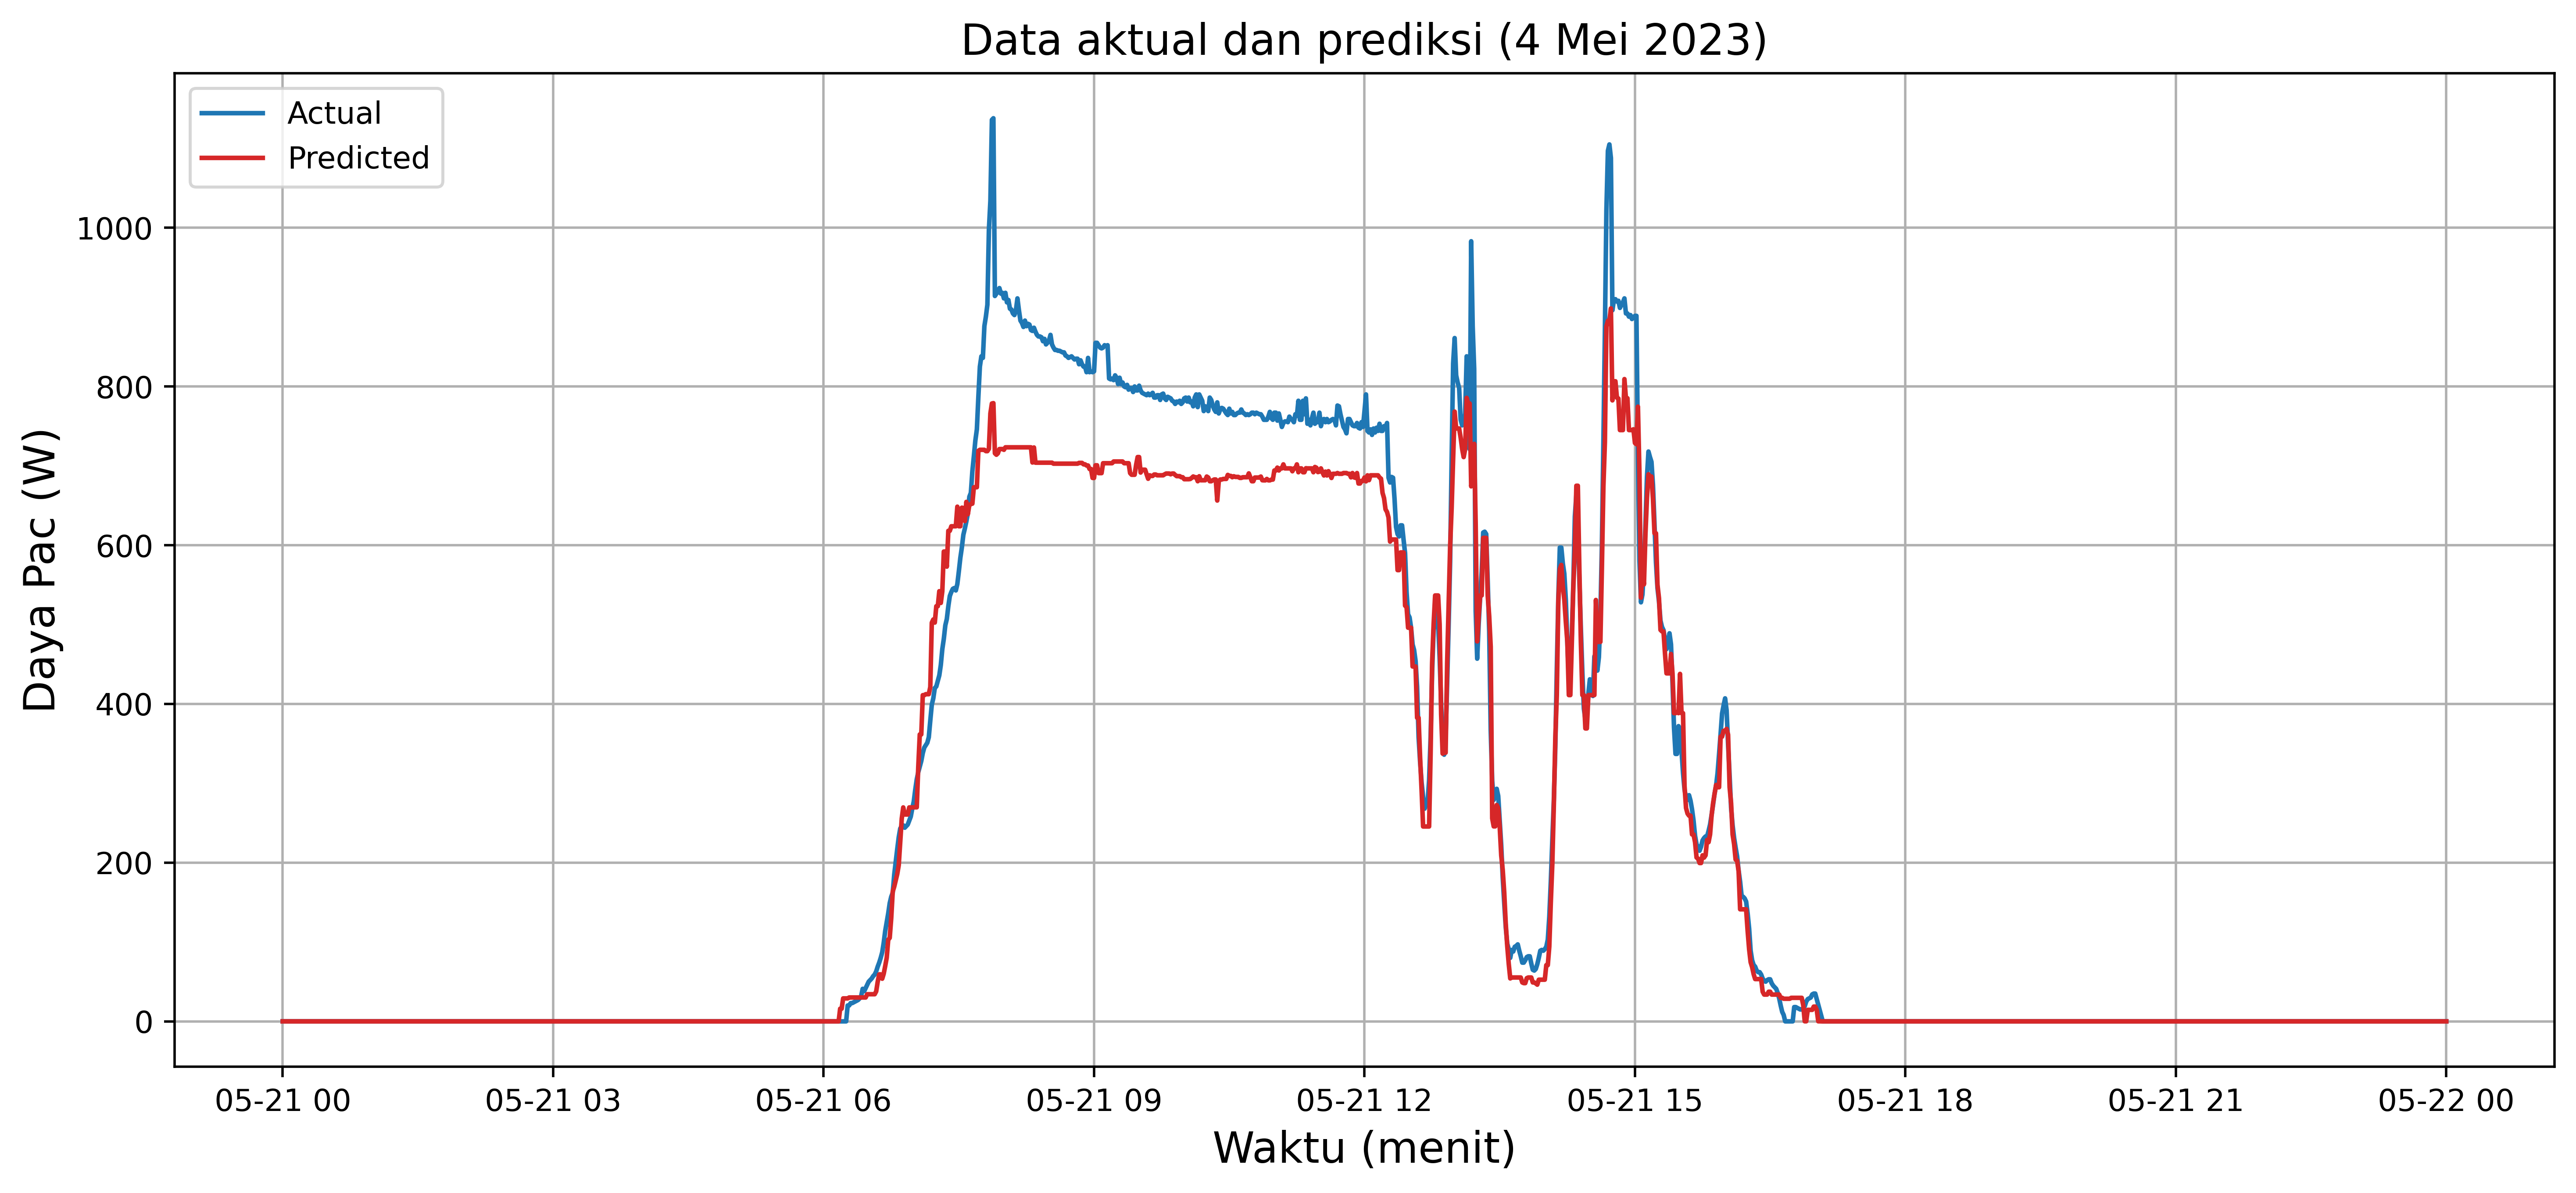

In [171]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df = pd.DataFrame(y_pred_reg, index=y_test_reg.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_actual = y_test_reg[(y_test_reg.index >= start_date) & (y_test_reg.index <= end_date)]
filtered_predicted = y_pred_reg_df[(y_pred_reg_df.index >= start_date) & (y_pred_reg_df.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual.index, filtered_actual, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted.index, filtered_predicted.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (4 Mei 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
#plt.savefig('Model3a.png')

# Menampilkan plot
plt.show()


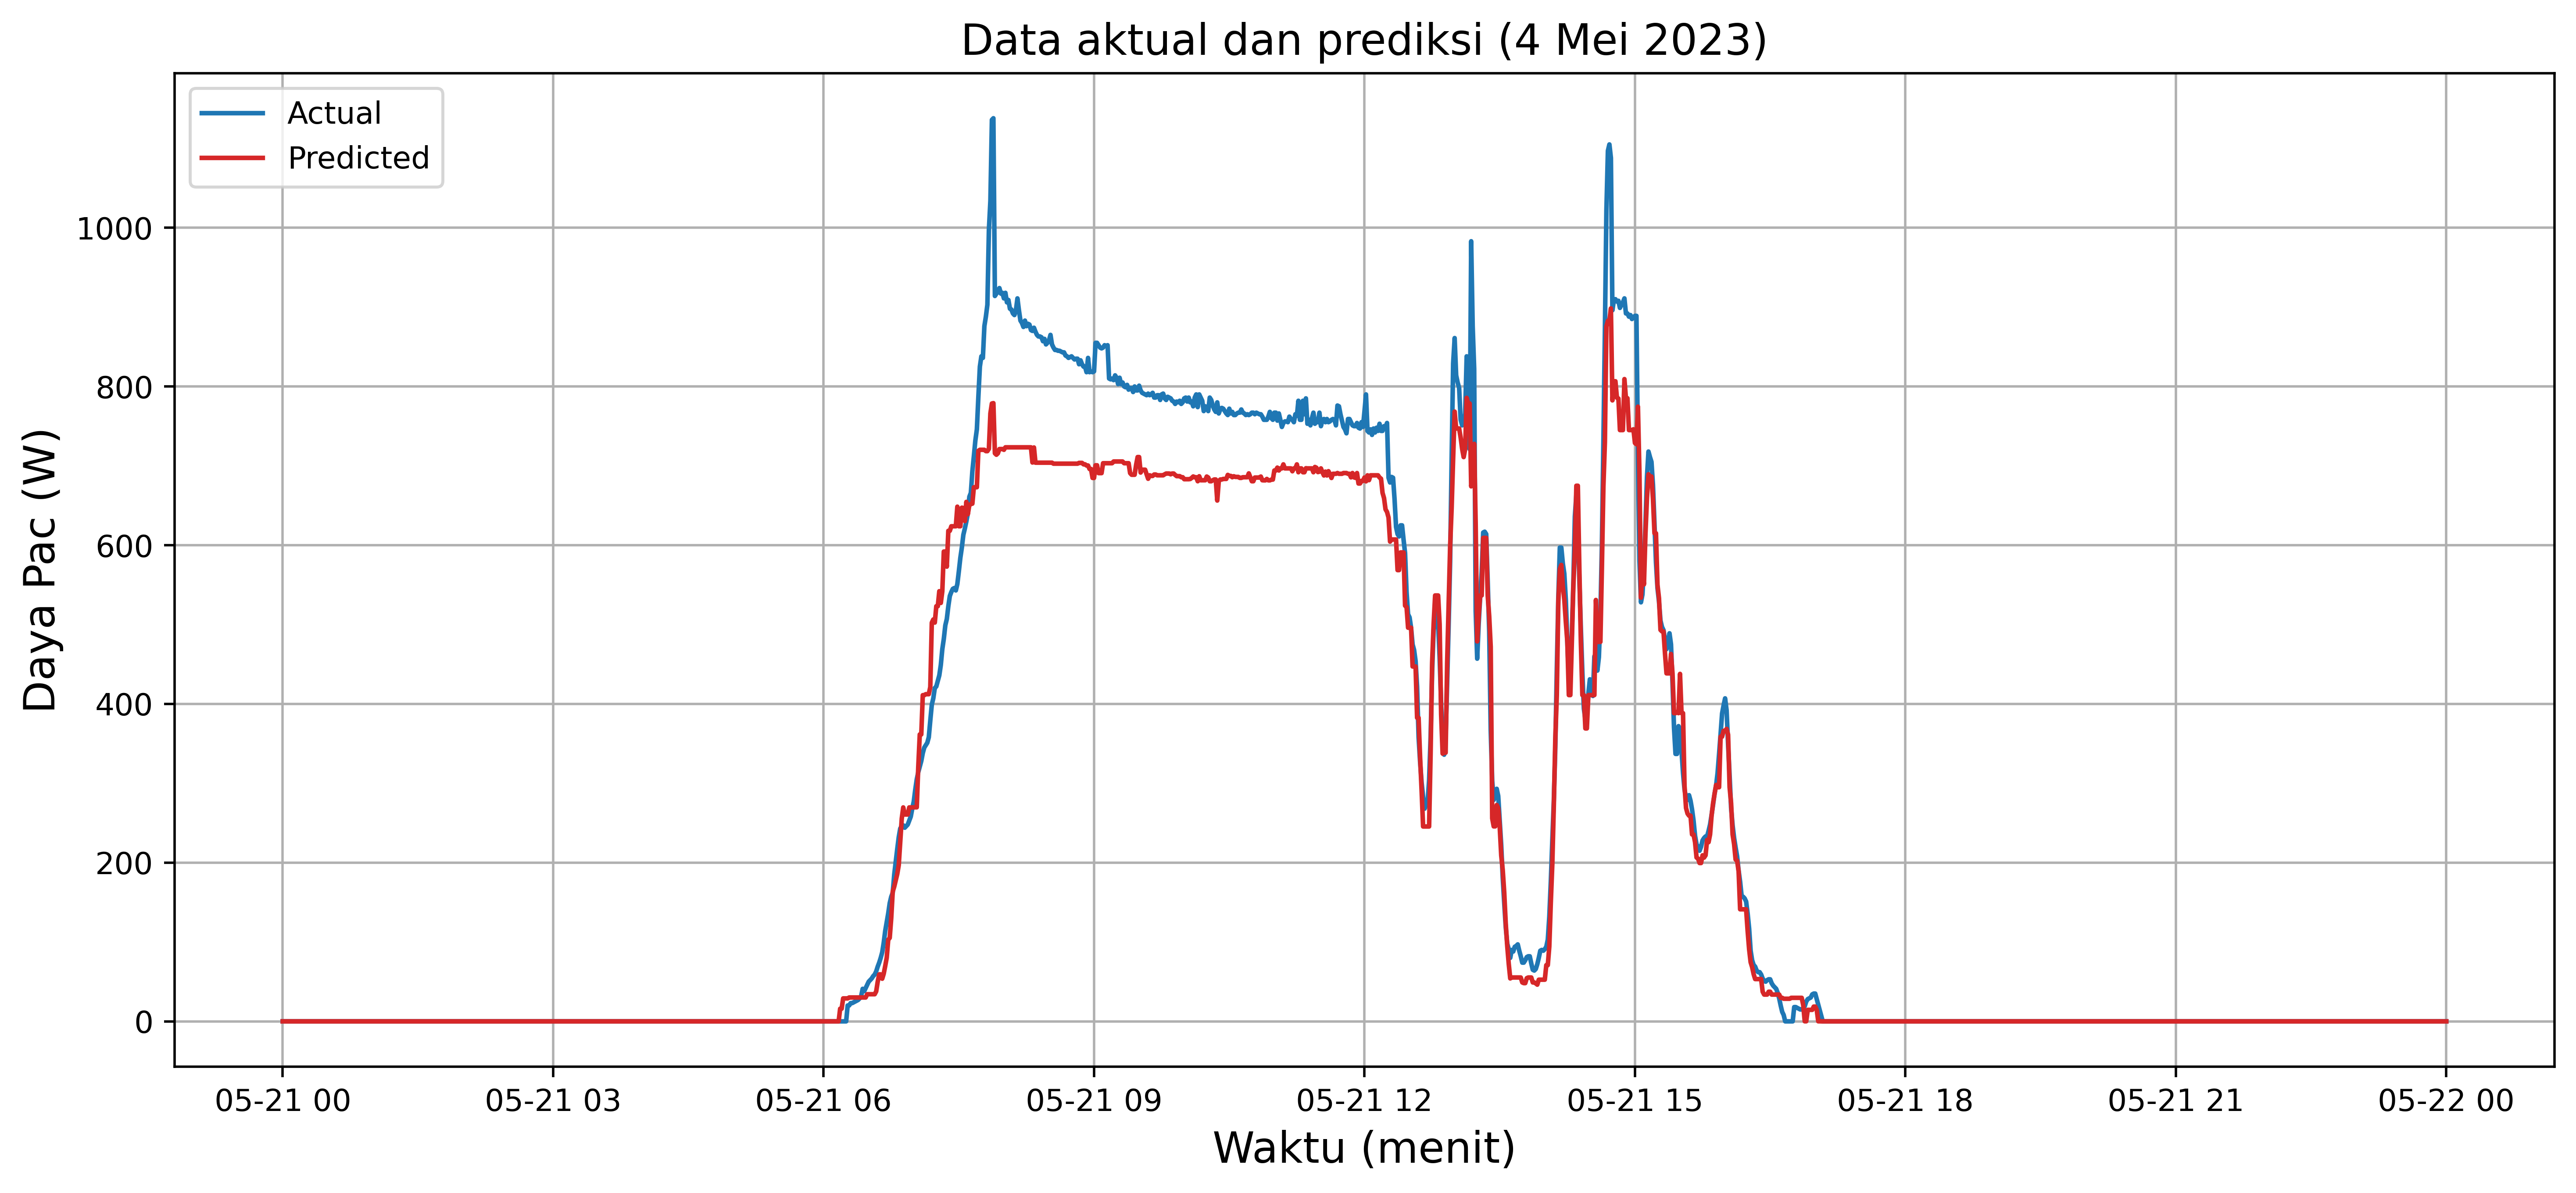

In [172]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df = pd.DataFrame(y_pred_reg, index=y_test_reg.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_actual = y_test_reg[(y_test_reg.index >= start_date) & (y_test_reg.index <= end_date)]
filtered_predicted = y_pred_reg_df[(y_pred_reg_df.index >= start_date) & (y_pred_reg_df.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual.index, filtered_actual, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted.index, filtered_predicted.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (4 Mei 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
plt.savefig('Model3a.png')

# Menampilkan plot
plt.show()


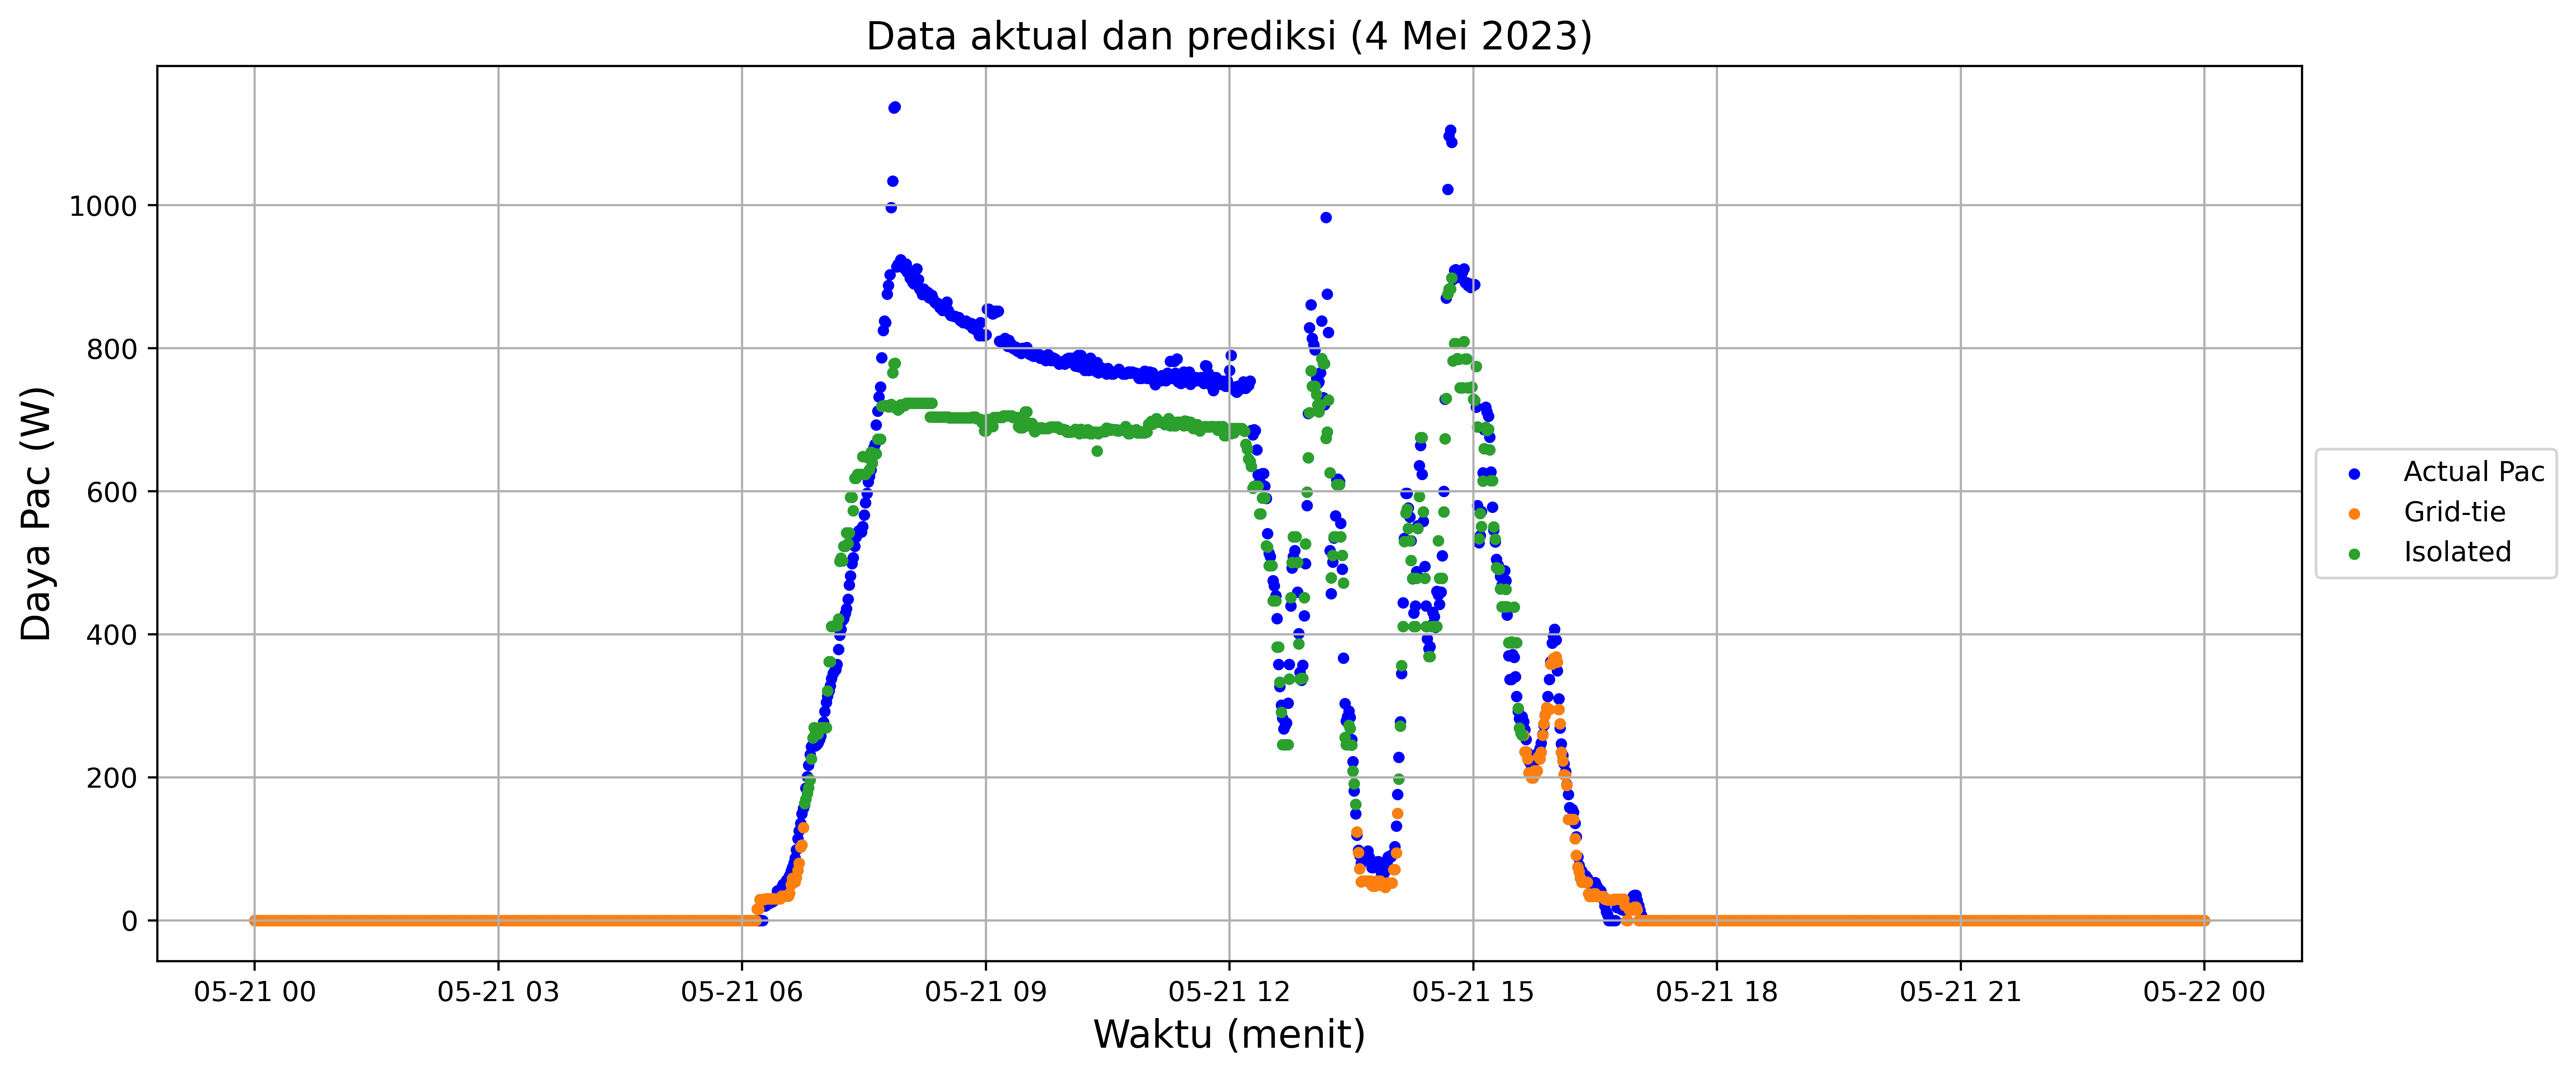

In [173]:
# Prediksi status operasi untuk setiap dataset (X_test_reg dan X_test_clf)
y_pred_clf = model_clf.predict(X_test_reg)

# Buat dataframe untuk menyimpan hasil prediksi
predictions_df = pd.DataFrame({
    'Timestamp': X_test_reg.index,  # Gunakan index sebagai timestamp
    'Actual_Pac': y_test_reg,  # Data aktual Pac
    'Predicted_Pac': y_pred_reg,  # Hasil prediksi Pac
    'Predicted_Status': y_pred_clf  # Hasil prediksi status operasi
})

# Pilih data hanya untuk satu bulan (misalnya, Oktober 2022)
start_date = '2023-5-21'
end_date = '2023-5-22'
filtered_data = predictions_df[(predictions_df['Timestamp'] >= start_date) & (predictions_df['Timestamp'] <= end_date)]

# Plot hasil prediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Scatter plot untuk Pac aktual
ax.scatter(filtered_data['Timestamp'], filtered_data['Actual_Pac'], label="Actual Pac", color='blue', s=10)

# Scatter plot untuk Pac yang diprediksi
ax.scatter(filtered_data['Timestamp'], filtered_data['Predicted_Pac'], s=10) #, label="Predicted Pac"

# Scatter plot untuk status operasi yang diprediksi
for status in filtered_data['Predicted_Status'].unique():
    status_data = filtered_data[filtered_data['Predicted_Status'] == status]
    label = "Grid-tie" if status == 0 else "Isolated"
    ax.scatter(status_data['Timestamp'], status_data['Predicted_Pac'], label=label, s=10)

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (4 Mei 2023)", fontsize=14)
ax.grid()

# Menampilkan legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Menyimpan plot ke file gambar
plt.savefig('Model3b.png')

# Menampilkan plot
plt.show()


In [174]:
# Filter hasil prediksi regresi yang negatif
negative_predictions_reg = y_pred_reg[y_pred_reg < 0]

# Print hasil prediksi regresi yang negatif
print("Hasil Prediksi Regresi yang Negatif:", negative_predictions_reg)
# Hitung jumlah baris hasil prediksi regresi yang negatif
jumlah_baris_negatif_reg = negative_predictions_reg.shape[0]

# Print jumlah baris hasil prediksi regresi yang negatif
print("Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif:", jumlah_baris_negatif_reg)


Hasil Prediksi Regresi yang Negatif: []
Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif: 0


In [179]:
from datetime import time

# Filter data untuk rentang waktu dari jam 18.02 sampai 05.30
filtered_df = predictions_df[
    ((predictions_df['Timestamp'].dt.hour == 18) & (predictions_df['Timestamp'].dt.minute >= 6)) |  # Jam 18:02 atau lebih
    (predictions_df['Timestamp'].dt.hour > 18) |  # Jam setelah 18:00
    ((predictions_df['Timestamp'].dt.hour == 5) & (predictions_df['Timestamp'].dt.minute <= 30))  # Jam 05:30 atau kurang
]

# Filter data dengan Predicted_Pac tidak nol
nonzero_predictions = filtered_df[filtered_df['Predicted_Pac'] != 0]

# Print informasi untuk Predicted_Pac tidak nol
print("Jumlah baris dengan Predicted_Pac tidak nol ketika tidak ada iradiansi :", nonzero_predictions.shape[0])
#print("Detail prediksi tidak nol:")
for index, row in nonzero_predictions.iterrows():
    print(f"Baris ke-{index}, Tanggal: {row['Timestamp'].date()}, Jam: {row['Timestamp'].time()}, Predicted_Pac: {row['Predicted_Pac']}")


Jumlah baris dengan Predicted_Pac tidak nol ketika tidak ada iradiansi : 0


In [180]:
import joblib
# Gabungkan model-regresi dan model-klasifikasi serta nama file model menjadi satu objek
combined_models = {
    'regression_model': model_custom_reg,
    'regression_model_file': 'regression_model.pkl',
    'classification_model': model_clf,
    'classification_model_file': 'classification_model.pkl'
}

# Simpan objek combined_models ke dalam file
joblib.dump(combined_models, 'Modelkondisi3baru.pkl')

['Modelkondisi3baru.pkl']

# Testing Validasi data lain

In [181]:
#validasi

In [182]:
# Test set untuk regresi
X_validasi_reg2 = validasi.drop(columns=['Pac'])
y_validasi_reg2 = validasi['Pac']
# Test set untuk klasifikasi
X_validasi_clf2 = validasi.drop(columns=['Op_GriSwStt'])
y_validasi_clf2 = validasi['Op_GriSwStt']

In [184]:
import time
# Mulai waktu
start_time = time.time()

df2_pred = model_custom_reg.predict(X_validasi_reg2)

# Hitung waktu yang dibutuhkan
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 269.89201378822327 seconds


In [185]:
# Evaluate regression model
mse_reg = mean_squared_error(y_validasi_reg2, df2_pred)
rmse_reg = np.sqrt(mse_reg)
R2_reg = r2_score(y_validasi_reg2, df2_pred)
MAE_reg = mean_absolute_error(y_validasi_reg2, df2_pred)
absolute_percentage_error_reg = np.abs((y_validasi_reg2 - df2_pred) / np.maximum(np.abs(y_validasi_reg2), 1)) * 100
mape_reg = np.mean(np.where(np.isfinite(absolute_percentage_error_reg), absolute_percentage_error_reg, 0))

print('Regression Model Metrics:')
print('Mean Squared Error on Test Set: ', mse_reg)
print('Root Mean Squared Error on Test Set: ', rmse_reg)
print('R2 Score on Test Set: ', r2_reg)
print('Mean Absolute Error on Test Set: ', MAE_reg)
print('Mean Absolute Percentage Error on Test Set: ', mape_reg, '%')
# Menghitung rata-rata dari data aktual dan hasil prediksi
actual_mean = np.mean
actual_mean = np.mean(y_validasi_reg2)
predicted_mean = np.mean(df2_pred)

# Menghitung bias
bias = actual_mean - predicted_mean

print('Rata-rata Actual:', actual_mean)
print('Rata-rata Predicted:', predicted_mean)
print('Bias:', bias)

Regression Model Metrics:
Mean Squared Error on Test Set:  56533.209453464144
Root Mean Squared Error on Test Set:  237.76713282845495
R2 Score on Test Set:  0.8926003934608162
Mean Absolute Error on Test Set:  93.92282227629599
Mean Absolute Percentage Error on Test Set:  100.57491083374397 %
Rata-rata Actual: 328.24722540156125
Rata-rata Predicted: 250.549428854434
Bias: 77.69779654712724


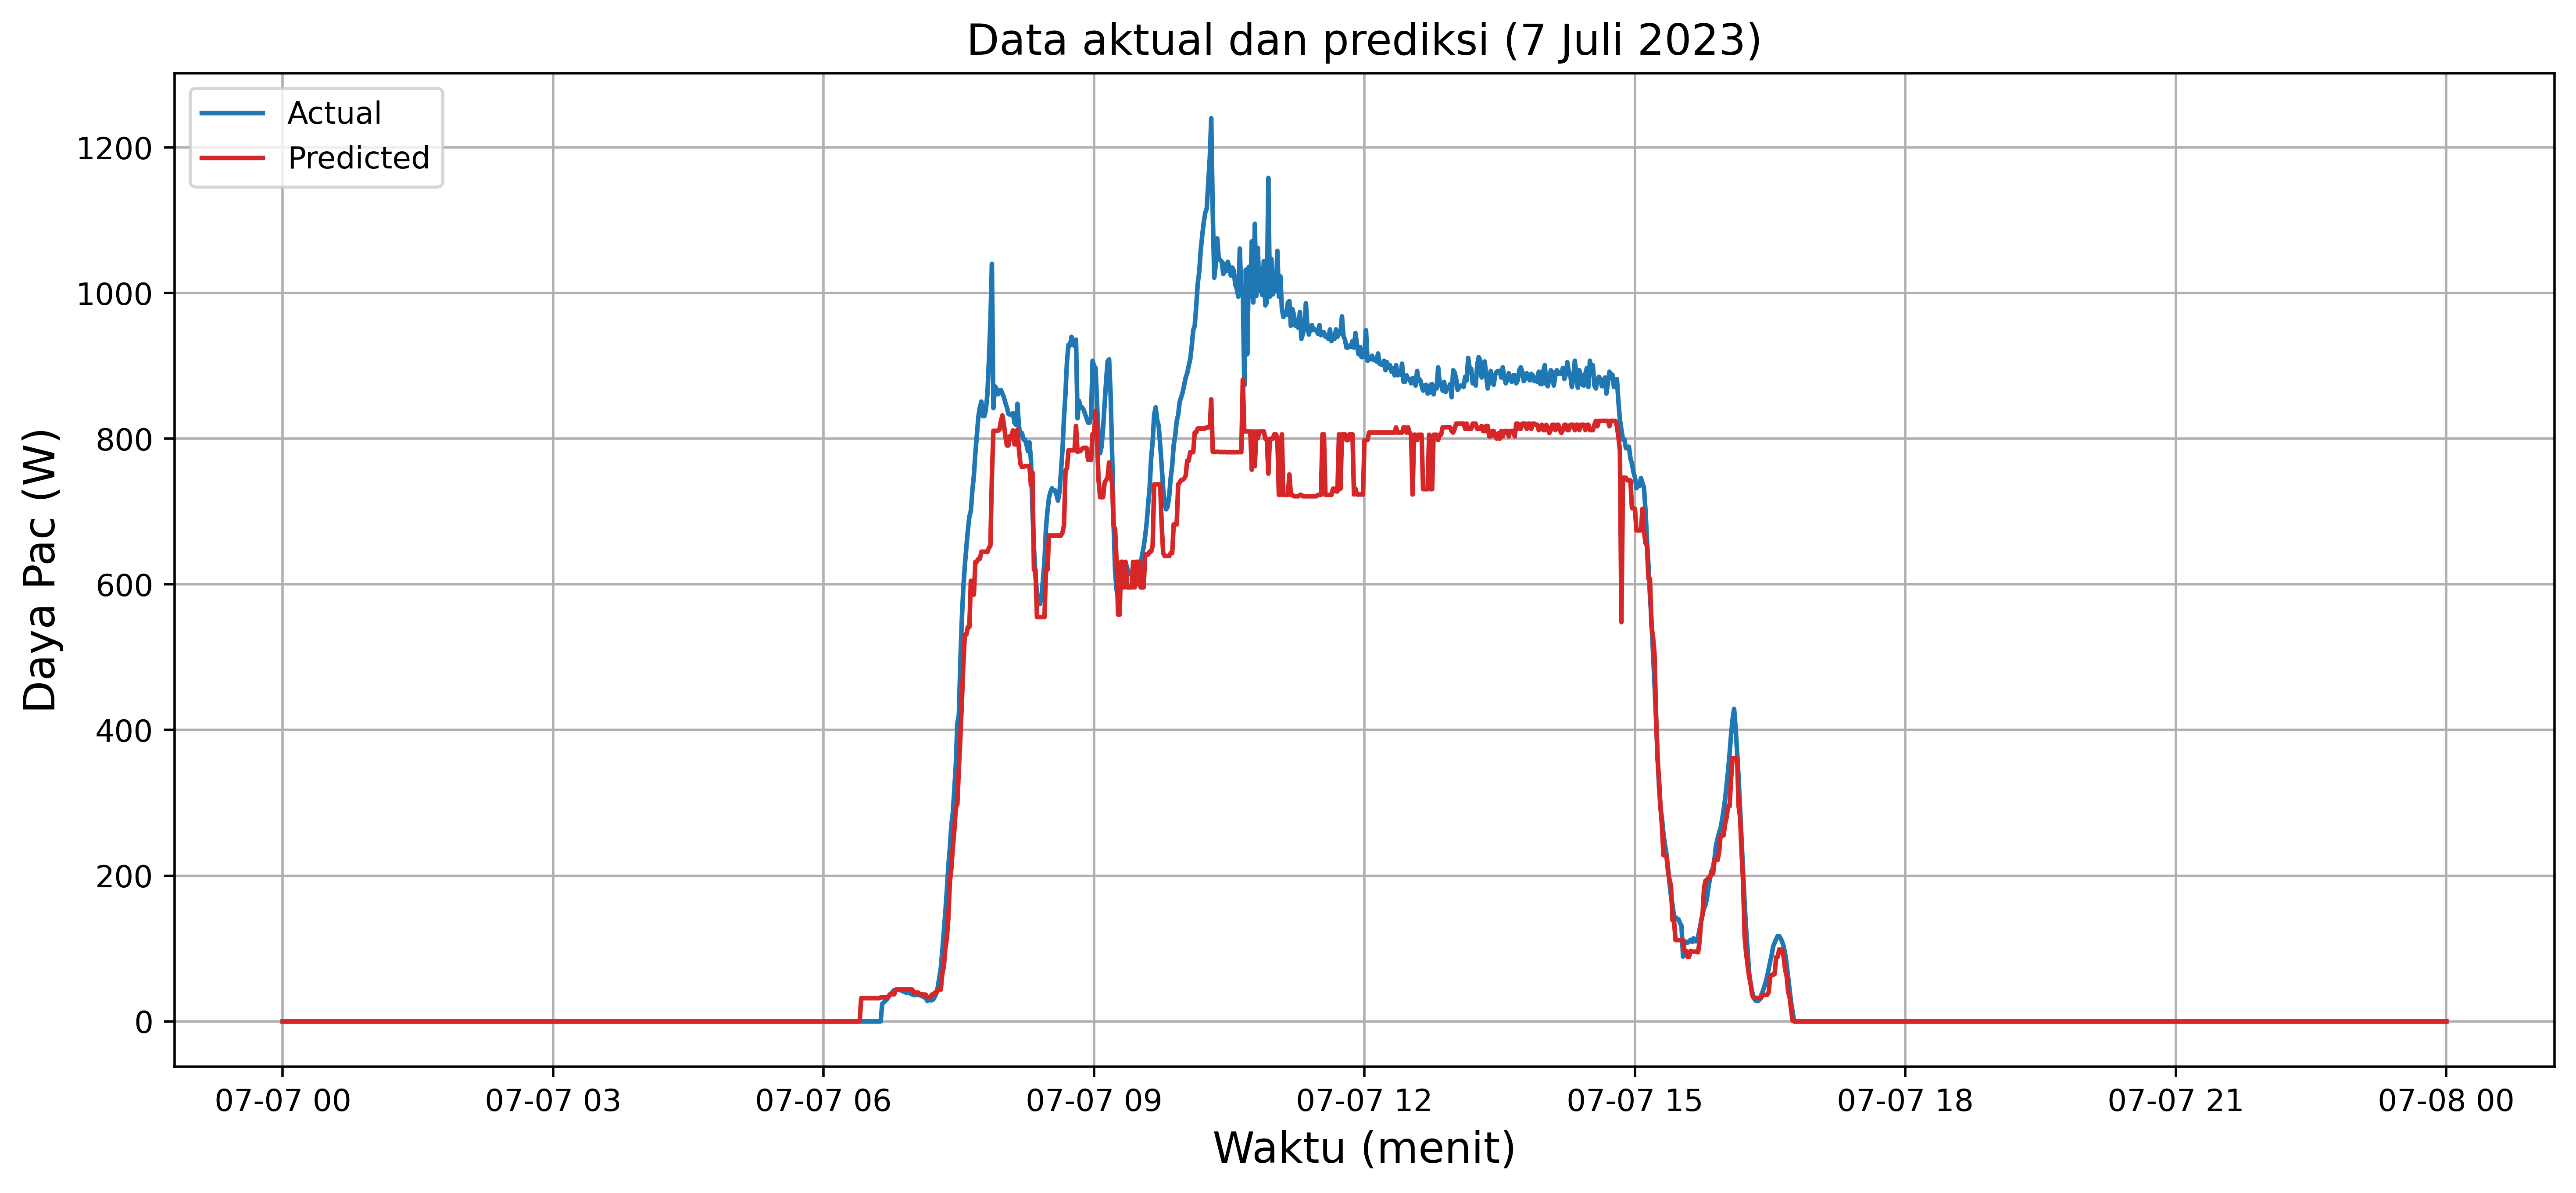

In [186]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame
y_pred_reg_df2 = pd.DataFrame(df2_pred, index=y_validasi_reg2.index)

# Filter data hanya untuk rentang tanggal yang ditentukan
start_date = '2023-7-07'
end_date = '2023-7-08'
filtered_actual2 = y_validasi_reg2[(y_validasi_reg2.index >= start_date) & (y_validasi_reg2.index <= end_date)]
filtered_predicted2 = y_pred_reg_df2[(y_pred_reg_df2.index >= start_date) & (y_pred_reg_df2.index <= end_date)]

# Plot data aktual dan data yang diprediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

# Plot data aktual
ax.plot(filtered_actual2.index, filtered_actual2, label="Actual", color='tab:blue')

# Plot data yang diprediksi (misalnya, kolom pertama dari hasil prediksi)
ax.plot(filtered_predicted2.index, filtered_predicted2.iloc[:, 0], label="Predicted", color='tab:red')

# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (7 Juli 2023)", fontsize=14)
ax.grid()

# Menampilkan legenda
ax.legend(loc='upper left')
# Menyimpan plot ke file gambar
plt.savefig('Model3c.png')

# Menampilkan plot
plt.show()


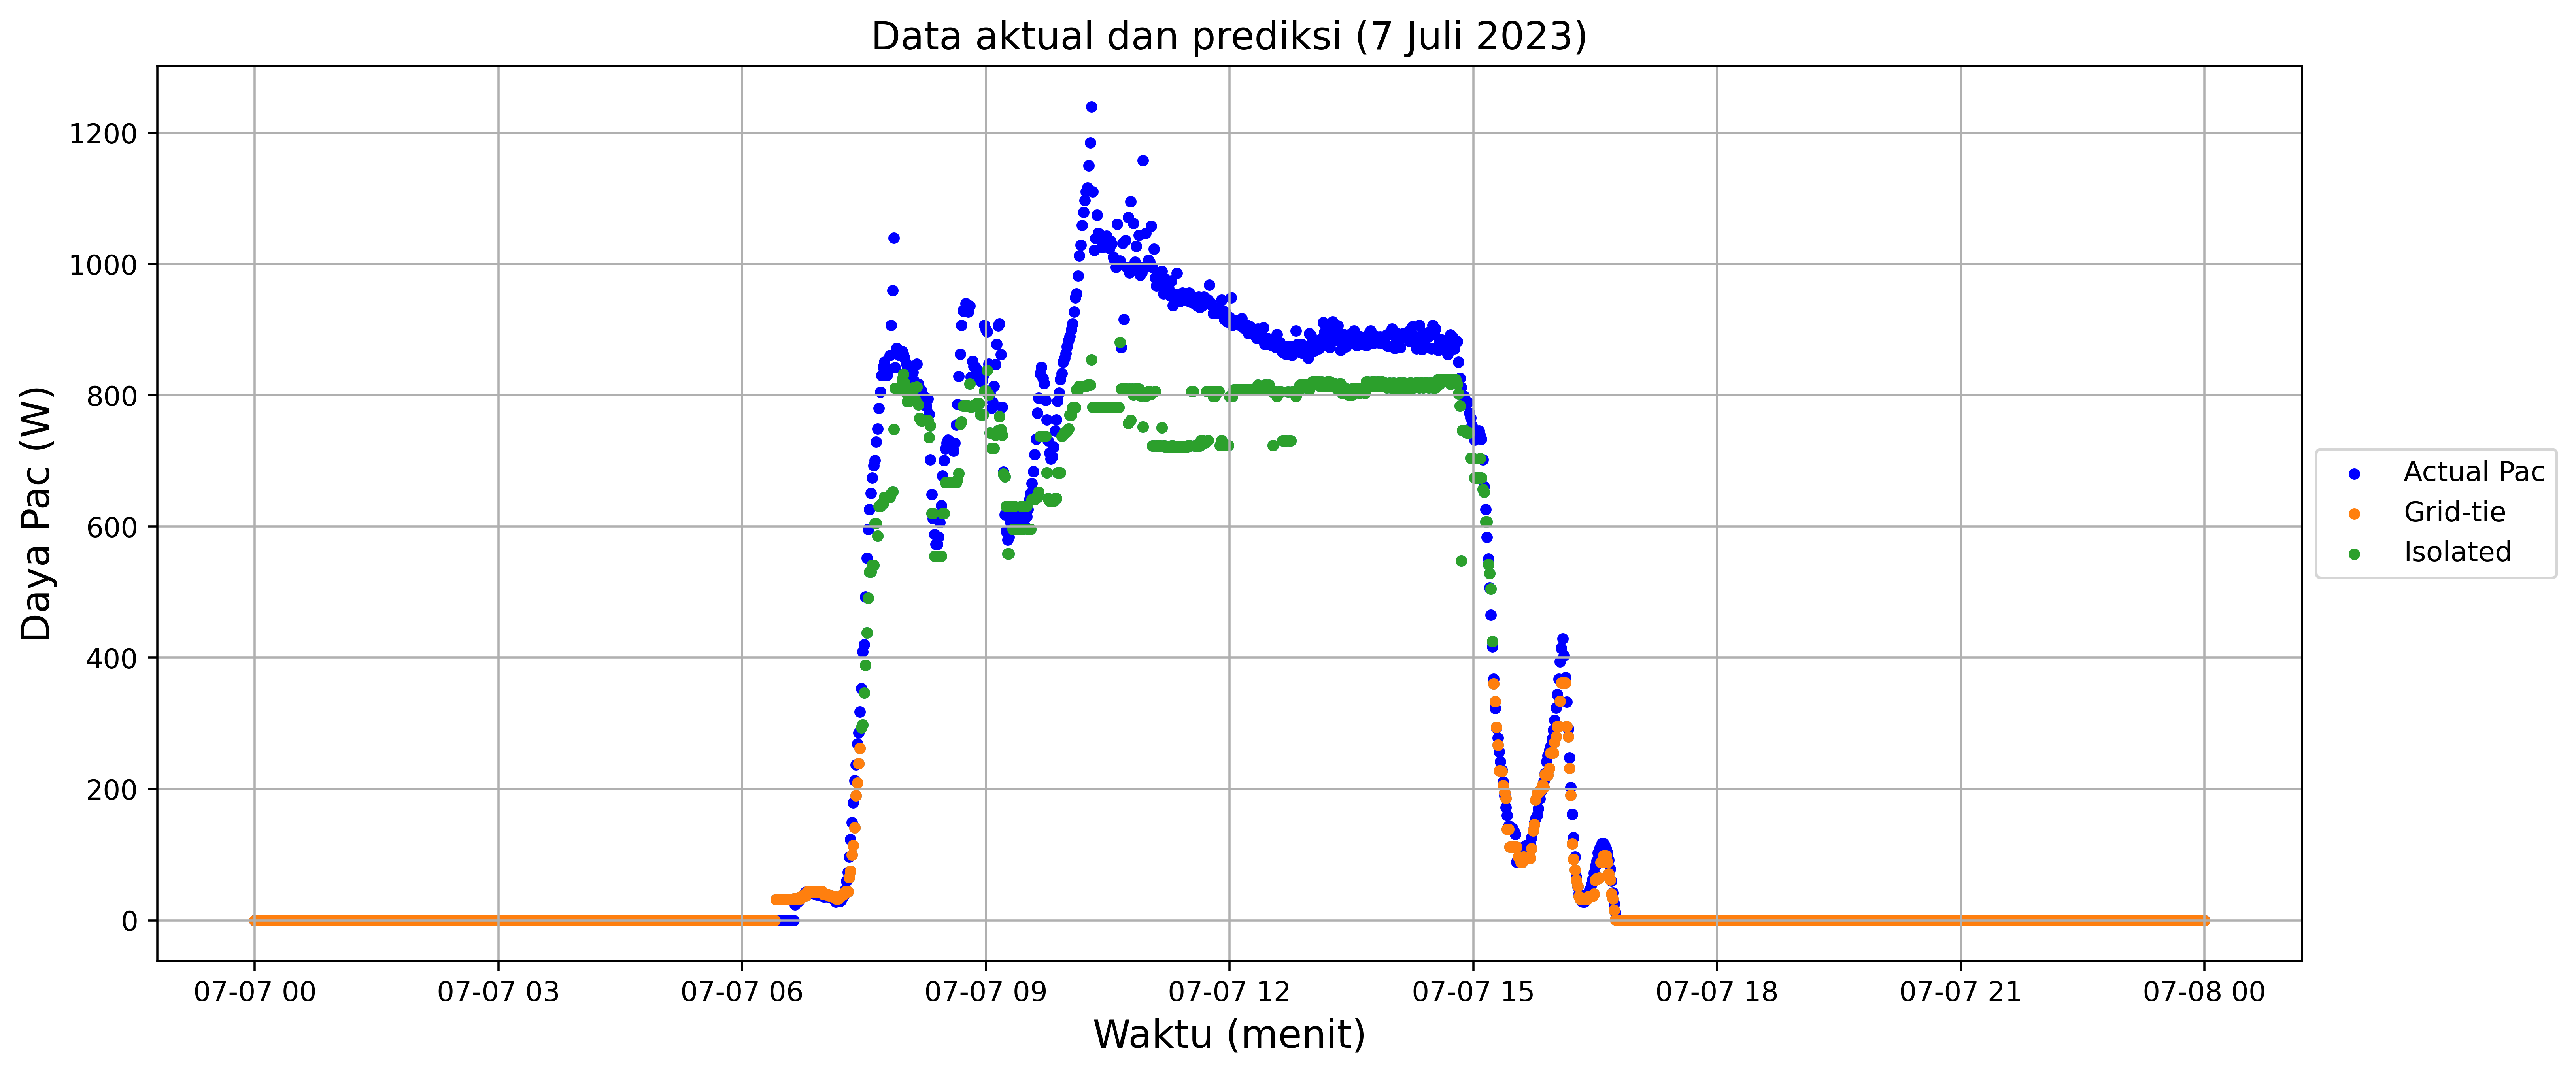

In [187]:
# Prediksi status operasi untuk setiap dataset (X_test_reg dan X_test_clf)
y_pred_clf2 = model_clf.predict(X_validasi_reg2)
# Buat dataframe untuk menyimpan hasil prediksi
predictions_df2 = pd.DataFrame({
    'Timestamp': X_validasi_reg2.index,  # Gunakan index sebagai timestamp
    'Actual_Pac': y_validasi_reg2,  # Data aktual Pac
    'Predicted_Pac': df2_pred,  # Hasil prediksi Pac
    'Predicted_Status': y_pred_clf2  # Hasil prediksi status operasi
})

# Pilih data hanya untuk satu bulan (misalnya, Oktober 2022)
start_date = '2023-07-07'
end_date = '2023-7-08'
filtered_data3 = predictions_df2[(predictions_df2['Timestamp'] >= start_date) & (predictions_df2['Timestamp'] <= end_date)]

# Plot hasil prediksi
fig, ax = plt.subplots(figsize=(14, 6), dpi=500)

   
# Scatter plot untuk Pac aktual
ax.scatter(filtered_data3['Timestamp'], filtered_data3['Actual_Pac'], label="Actual Pac", color='blue', s=10)

# Scatter plot untuk Pac yang diprediksi
ax.scatter(filtered_data3['Timestamp'], filtered_data3['Predicted_Pac'], s=10) #, label="Predicted Pac"

# Scatter plot untuk status operasi yang diprediksi
for status in filtered_data3['Predicted_Status'].unique():
    status_data = filtered_data3[filtered_data3['Predicted_Status'] == status]
    label = "Grid-tie" if status == 0 else "Isolated"
    ax.scatter(status_data['Timestamp'], status_data['Predicted_Pac'], label=label, s=10)
    
# Menambahkan legenda dan memposisikan di pojok kanan grafik
ax.legend(loc='upper right')
# Menambahkan label dan judul plot
ax.set_xlabel("Waktu (menit)", fontsize=14)
ax.set_ylabel("Daya Pac (W)", fontsize=14)
ax.set_title("Data aktual dan prediksi (7 Juli 2023)", fontsize=14)
ax.grid()
# Menampilkan legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Menyimpan plot ke file gambar
plt.savefig('Model3d.png')

# Menampilkan plot
plt.show()

In [188]:
# Evaluate classification model
accuracy_clf = accuracy_score(y_validasi_clf2, y_pred_clf2)
precision_clf = precision_score(y_validasi_clf2, y_pred_clf2)
recall_clf = recall_score(y_validasi_clf2, y_pred_clf2)
f1_clf = f1_score(y_validasi_clf2, y_pred_clf2)

print('Classification Model Metrics:')
print('Accuracy: ', accuracy_clf)
print('Precision: ', precision_clf)
print('Recall: ', recall_clf)
print('F1 Score: ', f1_clf)

Classification Model Metrics:
Accuracy:  0.910929924510346
Precision:  0.9098008073588776
Recall:  0.8674911660777385
F1 Score:  0.8881423818598791


In [189]:
# Filter hasil prediksi regresi yang negatif
negative_predictions_reg2 = df2_pred[df2_pred < 0]

# Print hasil prediksi regresi yang negatif
print("Hasil Prediksi Regresi yang Negatif:", negative_predictions_reg2)
# Hitung jumlah baris hasil prediksi regresi yang negatif
jumlah_baris_negatif_reg = negative_predictions_reg2.shape[0]

# Print jumlah baris hasil prediksi regresi yang negatif
print("Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif:", jumlah_baris_negatif_reg)


Hasil Prediksi Regresi yang Negatif: []
Jumlah Baris dengan Hasil Prediksi Regresi yang Negatif: 0


In [194]:
from datetime import time

# Ensure the 'Timestamp' column is in datetime format
predictions_df2['Timestamp'] = pd.to_datetime(predictions_df2['Timestamp'])

# Create a boolean mask for the time range from 18:02 to 05:30
mask = (
    ((predictions_df2['Timestamp'].dt.hour == 18) & (predictions_df2['Timestamp'].dt.minute >= 18)) |  # Jam 18:02 atau lebih
    (predictions_df2['Timestamp'].dt.hour > 18) |  # Jam setelah 18:00
    ((predictions_df2['Timestamp'].dt.hour == 4) & (predictions_df2['Timestamp'].dt.minute <= 30)) |  # Jam 05:30 atau kurang
    (predictions_df2['Timestamp'].dt.hour < 4)  # Jam sebelum 05:30
)

# Filter data for the specified time range
filtered_df2 = predictions_df2[mask]

# Filter data with Predicted_Pac not equal to zero
nonzero_predictions = filtered_df2[filtered_df2['Predicted_Pac'] != 0]

# Print information for non-zero Predicted_Pac
print("Jumlah baris dengan Predicted_Pac tidak nol pada rentang waktu 18.02-05.30:", nonzero_predictions.shape[0])
print("Detail prediksi tidak nol:")
for index, row in nonzero_predictions.iterrows():
    print(f"Baris ke-{index}, Tanggal: {row['Timestamp'].date()}, Jam: {row['Timestamp'].time()}, Predicted_Pac: {row['Predicted_Pac']}")


Jumlah baris dengan Predicted_Pac tidak nol pada rentang waktu 18.02-05.30: 0
Detail prediksi tidak nol:
